In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import collections
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
train = pd.read_csv('/content/drive/My Drive/머신러닝 데이터/data/train.csv')
test = pd.read_csv('/content/drive/My Drive/머신러닝 데이터/data/test.csv')

In [ ]:
# Data Preprocessing

train_img = train.iloc[:,3:].to_numpy().reshape(-1,28,28,1)
train_digit = train['digit']
train_letter = train['letter']
test_img = test.iloc[:,2:].to_numpy().reshape(-1,28,28,1)
test_letter = test['letter']

In [ ]:
train_img_norm = train_img / 255.0
test_img_norm = test_img / 255.0

In [ ]:
X_train = train_img_norm
y_train = train_digit.to_numpy()

X_test = test_img_norm

In [ ]:
from sklearn.model_selection import train_test_split

X_train_data, X_val_data, y_train_data, y_val_data = train_test_split(X_train, y_train, test_size = 0.2, random_state = 1004)

In [ ]:
def loss_plot(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                ax[i].plot(epochs, y)
                ax[i].set_title('Loss')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    ax[i].plot(epochs, y)
                    ax[i].set_title('Accuracy')
                    
    plt.show()

In [ ]:
Global_params = collections.namedtuple('Global_params', [
    'dropout_rate', 'batch_norm','batch_norm_momentum', 'batch_norm_epsilon', 'activation'
])
Block_params = collections.namedtuple('Block_params', [
    'channels', 'output_filters','kernel_size', 'strides', 'padding',
    'expand_ratio', 'se_ratio', 'num_repeat', 'block_number'
])

CONV_KERNEL_INITIALIZER = {
    'class_name' : 'VarianceScaling',
    'config' : {
        'scale' : 2.0,
        'mode' : 'fan_out',
        'distribution' : 'normal'
    }
}

DENSE_KERNEL_INITIALIZER = {
    'class_name' : 'VarianceScaling',
    'config' : {
        'scale' : 1.0 / 3.0,
        'mode' : 'fan_out',
        'distribution' : 'uniform'
    }
}

global_param = Global_params(dropout_rate=0.2, batch_norm=False, batch_norm_momentum=0.99,
                             batch_norm_epsilon=0.001, activation = 'relu')

Block_params_list = [
    Block_params(channels=128, output_filters=256, kernel_size = 3, strides=1, padding='same',
                 expand_ratio=3, se_ratio=0.25,num_repeat=9, block_number=2),
    Block_params(channels=256, output_filters=256, kernel_size = 3, strides=1, padding='same',
                expand_ratio=3, se_ratio=0.25,num_repeat=9, block_number=3),
    Block_params(channels=256, output_filters=256, kernel_size = 3, strides=1, padding='same',
                expand_ratio=3, se_ratio=0.25, num_repeat=1, block_number=4)
]

# MBConvBlock
- out : return the MBblock with seblocks.

# EfficientNet 

    
# **params**
- width_coefficient
- depth_coefficient
- default_resolution
- dropout_rate
- global_params
- block_params_list
- depth_divisor
- classes





# Function
- round_filters
- round_repeats

In [ ]:
def round_filters(filters, width_coefficient, depth_divisor):
    filters *= width_coefficient
    new_filters =int(filters + depth_divisor / 2) // depth_divisor * depth_divisor
    new_filters = max(depth_divisor, new_filters)
    if new_filters < 0.9 * filters:
        new_filters += depth_divisor
    return int(new_filters)

def round_repeats(repeats, depth_coefficient):
    return int(math.ceil(repeats * depth_coefficient))

In [ ]:
class MBConvBlock:

    def __init__(self, global_params, block_params):
        '''

        :param block_params: 'Block_parmas', the parameters of tensorflow layers
        :param global_params: 'Global_params'.
        '''
        self._dropout_rate = global_params.dropout_rate
        self._batch_norm = global_params.batch_norm
        self._batch_norm_momentum = global_params.batch_norm_momentum
        self._batch_norm_epsilon = global_params.batch_norm_epsilon
        self._activation = global_params.activation

        self._expand_ratio = block_params.expand_ratio
        self._se_ratio = block_params.se_ratio
        self._num_repeat = block_params.num_repeat
        self._channels = block_params.channels
        self._output_filters = block_params.output_filters
        self._kernel_size = block_params.kernel_size
        self._strides = block_params.strides
        self._padding = block_params.padding
        self.after_expand_filters = None
        self._block_number = block_params.block_number
        self.dropout = layers.Dropout(rate=self._dropout_rate, name = 'dropout{}'.format(self._block_number))

    def mbconv_block(self, input_tensor):
        # Expansion phase
        x = input_tensor

        if self._expand_ratio != 0:
            self.filters_expand = self._channels * self._expand_ratio
            x = layers.Conv2D(self.filters_expand,
                              kernel_size=(1, 1),
                              strides=1,
                              padding='same',
                              kernel_initializer=CONV_KERNEL_INITIALIZER,
                              name = 'conv{}_expand_{}'.format(self._block_number, self._repeat_number))(x)
            if self._batch_norm:
                x = layers.BatchNormalization(momentum=self._batch_norm_momentum,
                                              epsilon=self._batch_norm_epsilon,
                                              name = 'bn{}_expand_{}'.format(self._block_number, self._repeat_number))(x)
            x = layers.Activation(self._activation,
                                  name = 'activation{}_expand_{}'.format(self._block_number, self._repeat_number))(x)
        else:
            self.filters_expand = self._channels

        # Depthwise conv block
        x = layers.DepthwiseConv2D(kernel_size=self._kernel_size,
                                   strides=self._strides,
                                   padding=self._padding,
                                   depthwise_initializer=CONV_KERNEL_INITIALIZER,
                                   name = 'depth_conv{}_{}'.format(self._block_number, self._repeat_number))(x)
        if self._batch_norm:
            x = layers.BatchNormalization(momentum=self._batch_norm_momentum,
                                          epsilon=self._batch_norm_epsilon,
                                          name = 'depth_bn{}_{}'.format(self._block_number, self._repeat_number))(x)
        x = layers.Activation(self._activation,
                              name = 'depth_activation{}_{}'.format(self._block_number, self._repeat_number))(x)

        # SE Block
        x = self.se_block(x)

        # Output phase
        x = layers.Conv2D(self._output_filters,
                          kernel_size=(1, 1),
                          strides=1,
                          padding='same',
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name = 'conv{}_out_{}'.format(self._block_number, self._repeat_number))(x)
        if self._batch_norm:
            x = layers.BatchNormalization(momentum=self._batch_norm_momentum,
                                          epsilon=self._batch_norm_epsilon,
                                          name = 'bn{}_out_{}'.format(self._block_number, self._repeat_number))(x)

        return x

    def se_block(self, input_tensor):

        x = input_tensor
        # squeeze phase
        x = layers.GlobalAveragePooling2D(name = 'gap{}_squeeze{}'.format(self._block_number, self._repeat_number))(x)
        x = layers.Reshape((1, 1, -1), name = 'reshape{}_{}'.format(self._block_number, self._repeat_number))(x)

        # reduce phase
        reduced_filters = max(1, (self._channels * self._se_ratio))
        x = layers.Conv2D(reduced_filters,
                          kernel_size=(1, 1),
                          strides=1,
                          padding='same',
                          activation='relu',
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name = 'conv{}_relu_{}'.format(self._block_number, self._repeat_number))(x)
        x = layers.Conv2D(self.filters_expand,
                          kernel_size=(1, 1),
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer=CONV_KERNEL_INITIALIZER,
                          name = 'conv{}_sigmoid_{}'.format(self._block_number, self._repeat_number))(x)

        x = layers.multiply([input_tensor, x], name = 'excite{}_{}'.format(self._block_number, self._repeat_number))

        return x

    def out(self, input_tensors):
        '''

        :param input_tensors: 'tensor', a previous tensors
        :return: an output tensors
        '''

        x = input_tensors

        for i in range(self._num_repeat):
            self._repeat_number = i
            if i == 0:
                x = self.mbconv_block(x)
            else:
                self._channels = self._output_filters
                self._strides = 1
                x_indentity = tf.identity(x, name = 'identity{}_{}'.format(self._block_number, self._repeat_number))
                x = self.mbconv_block(x)
                x = self.dropout(x)
                x = layers.add([x_indentity, x], name = 'add{}_{}'.format(self._block_number, self._repeat_number))

        return x

In [ ]:
def EfficientNet(width_coefficient,
                 depth_coefficient,
                 default_resolution,
                 dropout_rate,
                 global_params,
                 block_params_list,
                 depth_divisor=8,
                 classes=10,
                 ):

    input = layers.Input(shape=(default_resolution, default_resolution, 1))
    x = layers.Conv2D(128,
                      kernel_size=(3, 3),
                      strides=1,
                      padding='same',
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name = 'conv1')(input)
    if global_params.batch_norm:
        x = layers.BatchNormalization(momentum=global_params.batch_norm_momentum,
                                      epsilon=global_params.batch_norm_epsilon,
                                      name = 'batch_normalization1'
                                      )(x)
    x = layers.Activation(global_params.activation, name = 'activation1')(x)

    for i in range(len(block_params_list)):
        args = block_params_list[i]
        args = args._replace(channels=round_filters(args.channels, width_coefficient, depth_divisor),
                             output_filters=round_filters(args.output_filters, width_coefficient, depth_divisor),
                             num_repeat=round_repeats(args.num_repeat, depth_coefficient))

        x = MBConvBlock(global_params, args).out(x)
        x = layers.MaxPool2D((2, 2), 2, name = 'pool{}'.format(i))(x)
    '''
    x = layers.Conv2D(256,
                      kernel_size=(1, 1),
                      strides=1,
                      padding='same',
                      kernel_initializer=CONV_KERNEL_INITIALIZER,
                      name = 'conv5')(x)
    if global_params.batch_norm:
        x = layers.BatchNormalization(momentum=global_params.batch_norm_momentum,
                                      epsilon=global_params.batch_norm_epsilon
                                      name = 'bn5')(x)

    x = layers.Activation(global_params.activation, name = 'activation5')(x)
    '''

    # FC layers
    img_features = layers.Flatten()(x)
    img_features = layers.Dense(512, kernel_initializer=DENSE_KERNEL_INITIALIZER, name='fc_1')(img_features)
    img_features = layers.Activation('relu', name='fc_activation_1')(img_features)
    img_features = layers.Dropout(rate=dropout_rate, name='fc_dropout_1')(img_features)
    img_features = layers.Dense(512, kernel_initializer=DENSE_KERNEL_INITIALIZER, name='fc_2')(img_features)
    img_features = layers.Activation('relu', name='fc_activation_2')(img_features)
    img_features = layers.Dropout(rate=dropout_rate, name='fc_dropout_2')(img_features)
    predictions = layers.Dense(classes,
                               activation='softmax',
                               kernel_initializer=DENSE_KERNEL_INITIALIZER,
                               name = 'prediction')(img_features)

    model = tf.keras.Model(inputs=input, outputs=predictions)

    return model

#Trainig Function

In [ ]:
def train_model_v1(model, X_train, y_train, X_val, y_val ,epochs, batch_size = None):
      
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 20, restore_best_weights = True)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = (X_val, y_val), callbacks = [callback])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

def train_model_v2(model, X_train, y_train, X_val, y_val, epochs, batch_size = None):
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
    
    history = model.fit(x = X_train, y = y_train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = (X_val, y_val), callbacks = [callback])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist

def train_model_v3(model, X_train, y_train, X_val, y_val, epochs, batch_size = None, validation_split = 0.1, set_seed = 1004):
      
      from tensorflow.keras.preprocessing.image import ImageDataGenerator

      callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 20, restore_best_weights = True)

      train_gen = ImageDataGenerator(width_shift_range = 2,
                                 height_shift_range = 2,
                                 rotation_range = 5,
                                 zoom_range=0.05,
                                fill_mode='nearest')

      history = model.fit(train_gen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, shuffle = True,
                          validation_data = (X_val, y_val),callbacks = [callback])

      epochs = history.epoch
      hist = pd.DataFrame(history.history)
  

      return epochs, hist

#Model Training

In [ ]:
width_coefficient = 1.0
depth_coefficient = 1.0
default_resolution = 28
dropout_rate = 0.4
learning_rate = 0.00001

EfficientNet_1 = EfficientNet(width_coefficient,
                              depth_coefficient,
                              default_resolution,
                              dropout_rate,
                              global_param,
                              Block_params_list)
EfficientNet_1.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                       loss = 'sparse_categorical_crossentropy',
                       metrics = ['accuracy'])
EfficientNet_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 28, 28, 128)  1280        input_1[0][0]                    
__________________________________________________________________________________________________
activation1 (Activation)        (None, 28, 28, 128)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2_expand_0 (Conv2D)         (None, 28, 28, 384)  49536       activation1[0][0]                
_______________________________________________________________________________________

Epoch 1/200
1638/1638 [==============================] - 40s 25ms/step - loss: 2.3099 - accuracy: 0.1117 - val_loss: 2.2927 - val_accuracy: 0.1244
Epoch 2/200
1638/1638 [==============================] - 40s 24ms/step - loss: 2.2888 - accuracy: 0.1294 - val_loss: 2.2811 - val_accuracy: 0.1098
Epoch 3/200
1638/1638 [==============================] - 39s 24ms/step - loss: 2.2611 - accuracy: 0.1600 - val_loss: 2.2293 - val_accuracy: 0.2341
Epoch 4/200
1638/1638 [==============================] - 39s 24ms/step - loss: 2.1973 - accuracy: 0.1880 - val_loss: 2.1295 - val_accuracy: 0.2756
Epoch 5/200
1638/1638 [==============================] - 39s 24ms/step - loss: 2.0754 - accuracy: 0.2363 - val_loss: 2.0255 - val_accuracy: 0.2951
Epoch 6/200
1638/1638 [==============================] - 39s 24ms/step - loss: 1.9710 - accuracy: 0.2753 - val_loss: 1.9292 - val_accuracy: 0.3659
Epoch 7/200
1638/1638 [==============================] - 39s 24ms/step - loss: 1.8473 - accuracy: 0.3254 - val_loss: 1

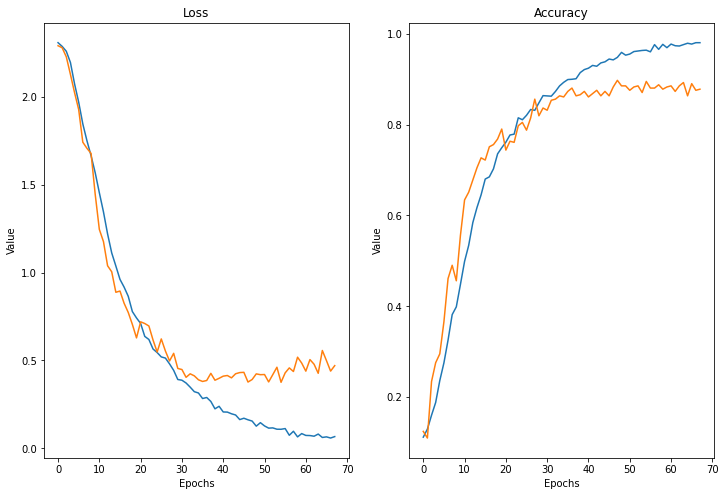

In [ ]:
## Model Test용
batch_size = 1
epochs = 200

epoch, hist = train_model_v1(EfficientNet_1, X_train_data, y_train_data, X_val_data, y_val_data, epochs, batch_size)

list_of_metrics_to_plot = ['loss','val_loss','accuracy','val_accuracy']
loss_plot(epoch, hist, list_of_metrics_to_plot)